# Histogram plots for temp and humid (DC, GH & OUT)

## Import dependencies and data

In [1]:
# import dependencies
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# set seaborn style/theme
sns.set_theme()
sns.set_style('white')

In [29]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [30]:
# Calc. temperature Diff. w.r.t. setpoint
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

In [31]:
# keep only temp & flow
data = data[[
    'temperatures',
    'flow',
]].copy()

# filter out variables
data = data.filter(
    regex='TA01_GT10X_GM10X|DC_GT401_GM401|TA01_GP101_default|DC_GT301', 
    axis=1
)

In [32]:
# drop top column index level
data = data.droplevel(
    level=0,
    axis=1
)

In [33]:
# drop cols w. high correlation
data = data.drop(columns=[
    #'TA01_GT10X_GM10X',
    'TA01_GT10X_GM10X_diff',
    'DC_GT301_outdoor'
    
])

In [9]:
# Filter data w. MASK (remove feb)
#mask = data.index.get_level_values(0) == 2
#data = data[~mask]

## Normalize and group data

In [34]:
## normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [35]:
# get data f. hourly and daily
dataNorm = data.copy()
dataDaily = data.groupby(['month', 'day']).mean().copy()
dataHourly = data.groupby(['month', 'day', 'hour']).mean().copy()

del data

## Correlation matrices

### Daily data

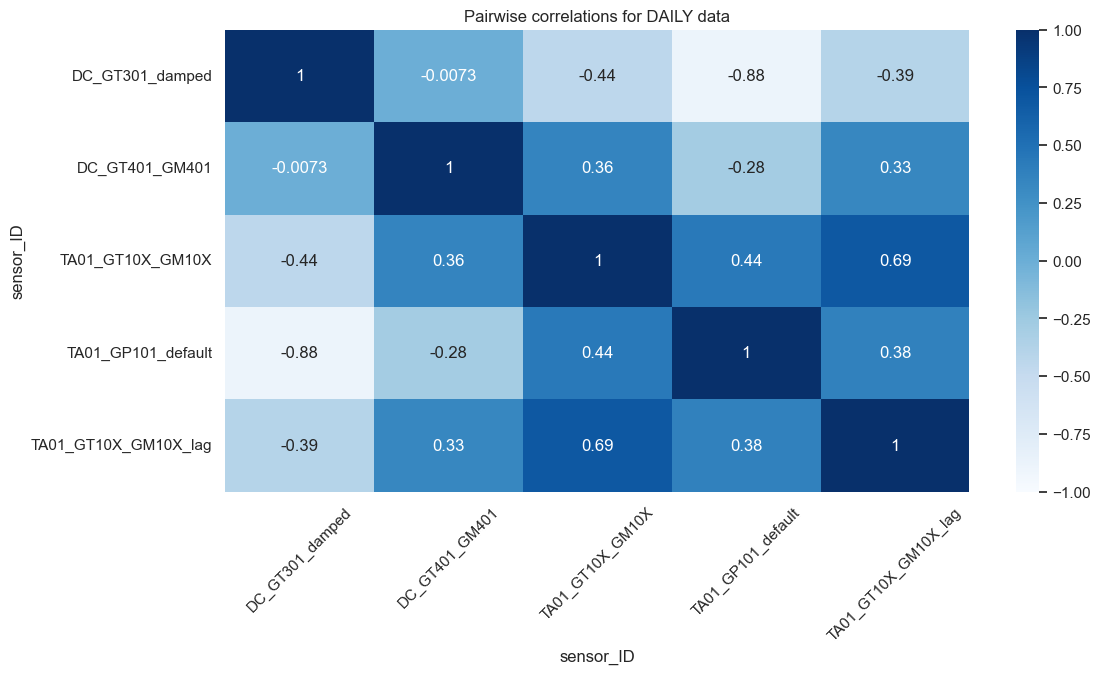

In [12]:
# get temp LAG (1 day)
dataDaily['TA01_GT10X_GM10X_lag'] = dataDaily.TA01_GT10X_GM10X.shift(periods=1)
dataDaily = dataDaily.iloc[1:]

# get correlations
corr = dataDaily.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

#mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

plt.xticks(rotation=45)
plt.title('Pairwise correlations for DAILY data')
plt.show()

# delete correlation data
del corr

### Hourly data

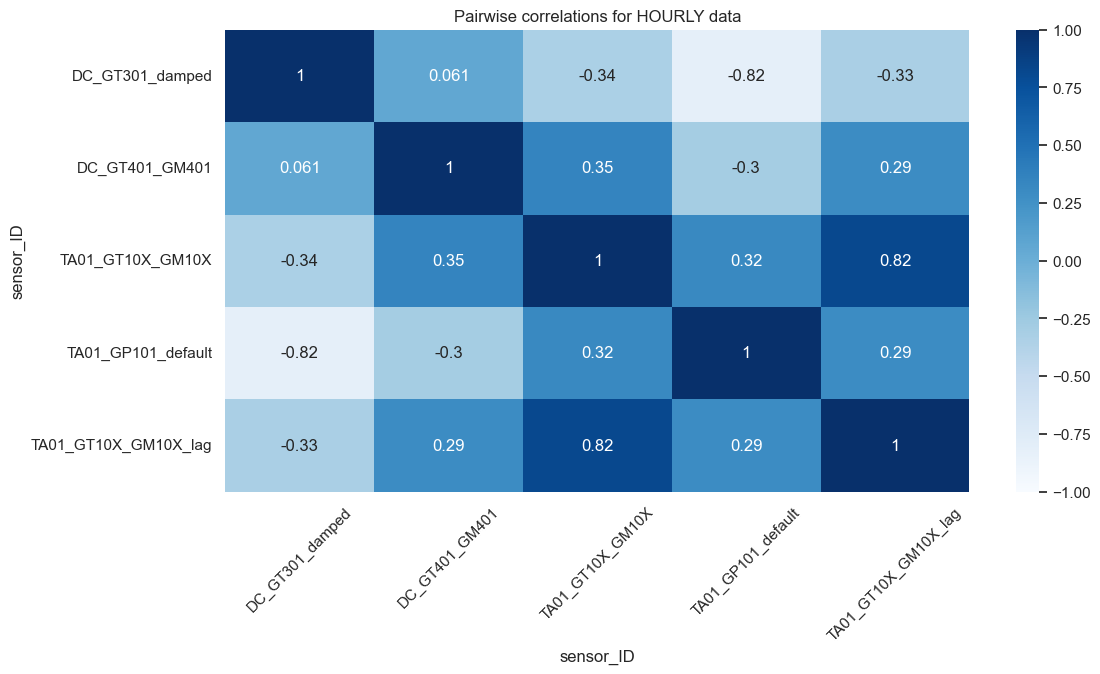

In [13]:
# get temp LAG (1 hour)
dataHourly['TA01_GT10X_GM10X_lag'] = dataHourly.TA01_GT10X_GM10X.shift(periods=1)
dataHourly = dataHourly.iloc[1:]

# get correlations
corr = dataHourly.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

#mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

plt.xticks(rotation=45)
plt.title('Pairwise correlations for HOURLY data')
plt.show()

# delete correlation data
del corr

### Normal frequency data (30 sec.)

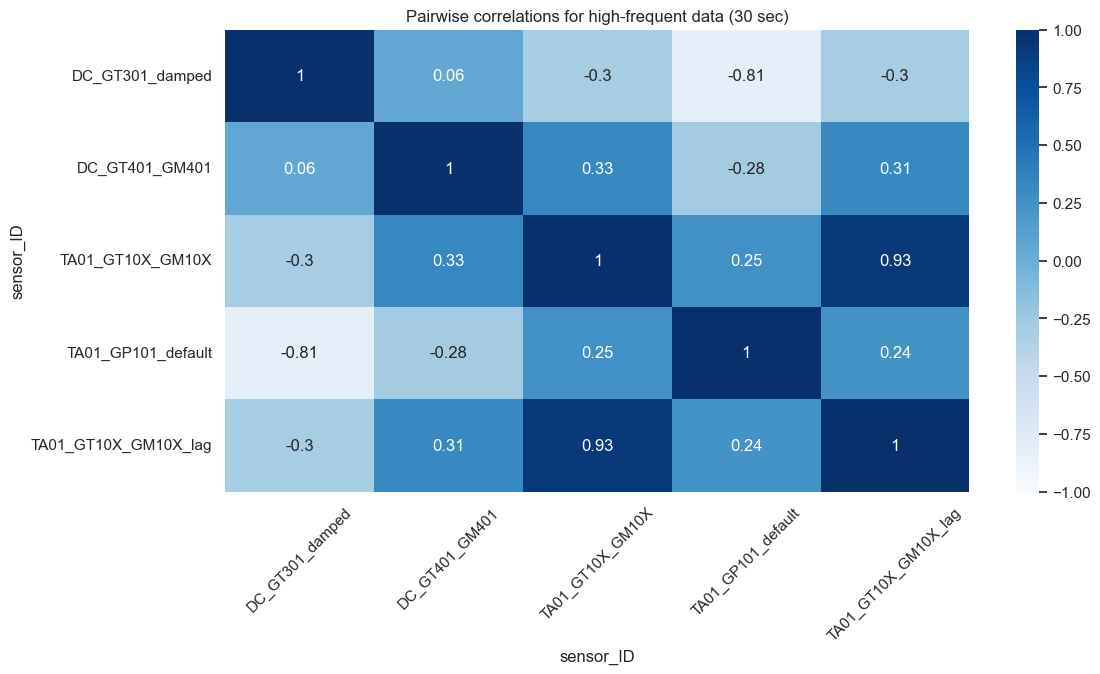

In [14]:
# get temp LAG (5 mins)
dataNorm['TA01_GT10X_GM10X_lag'] = dataNorm.TA01_GT10X_GM10X.shift(periods=10)
dataNorm = dataNorm.iloc[10:]

# get correlations
corr = dataNorm.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

#mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True, cmap='Blues')

plt.xticks(rotation=45)
plt.title('Pairwise correlations for high-frequent data (30 sec)')
plt.show()

# delete correlation data
del corr

## Airflow vs. temp data 

### Daily data

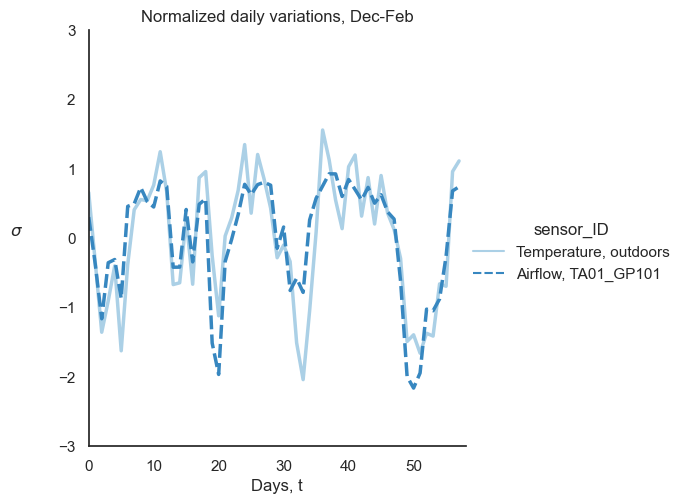

In [49]:
subset = dataDaily[[
    'DC_GT301_damped',
    'TA01_GP101_default'
]].copy()

# flip flow variable
subset['TA01_GP101_default'] = (-1) * subset['TA01_GP101_default'].values

subset = subset.rename(columns={
    'DC_GT301_damped':'Temperature, outdoors',
    'TA01_GP101_default':'Airflow, TA01_GP101'
})

## drop all index levels except date
#subset = subset.droplevel(
#    level=1, 
#    axis=0
#)

subset.reset_index(drop=True, inplace=True)

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='Blues',
    linewidth=2.5
)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(0, len(subset))
plt.ylim(-3, 3)

plt.xlabel('Days, t')
plt.ylabel('$\sigma$', loc='center', rotation=0, fontsize=12, labelpad=30)

plt.title('Normalized daily variations, Dec-Feb')
plt.savefig(plot_path + 'norm_daily_tempflow.png', bbox_inches='tight', dpi=500)


plt.show()

### Hourly data

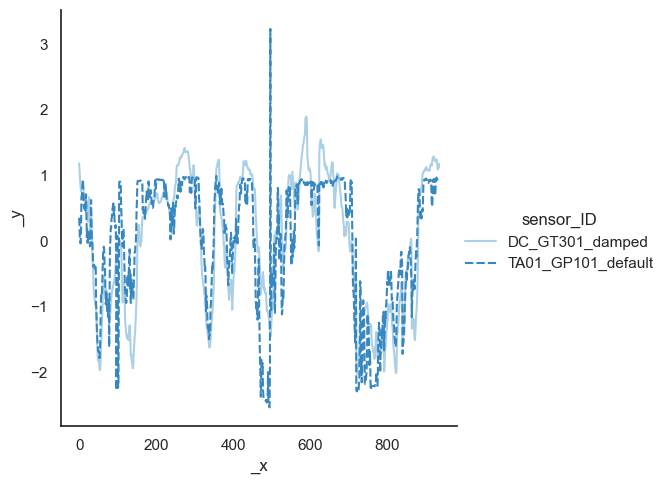

In [18]:
subset = dataHourly[[
    'DC_GT301_damped',
    'TA01_GP101_default'
]].copy()

# flip flow variable
subset['TA01_GP101_default'] = (-1) * subset['TA01_GP101_default'].values

## drop all index levels except date
#subset = subset.droplevel(
#    level=1, 
#    axis=0
#)

subset.reset_index(drop=True, inplace=True)

sns.relplot(
    data=subset,
    kind='line',
    palette='Blues',
    linewidth=1.5,
    dashes=True
)
plt.show()

### Normal data

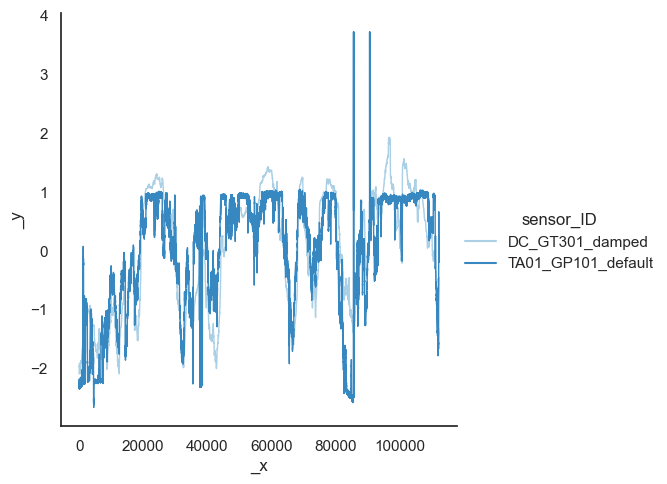

In [17]:
subset = dataNorm[[
    'DC_GT301_damped',
    'TA01_GP101_default'
]].copy()

# flip flow variable
subset['TA01_GP101_default'] = (-1) * subset['TA01_GP101_default'].values

## drop all index levels except date
#subset = subset.droplevel(
#    level=1, 
#    axis=0
#)

subset.reset_index(drop=True, inplace=True)

sns.relplot(
    data=subset,
    kind='line',
    palette='Blues',
    linewidth=1.0,
    dashes=False
)
plt.show()